# Red Wine Quality Prediction

Goal: To predict red wine quality based on physicochemical tests

# About the Data

The dataset is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available.

# Features and Descriptions

| Variable Name | Role | Variable Type | Description | 
| :- | :- | :- | :- |
| fixed_acidity | Feature | Continuous | g(tartaric acid)/dm^3 | 
| volatile_acidity | Feature | Continuous | g(acetic acid)/dm^3 | 
| citric_acidity | Feature | Continuous | g/dm^3 |
| residual_sugar | Feature | Continuous | g/dm^3 |
| chlorides | Feature | Continuous | g(sodium chloride)/dm^3 |
| free_sulfur_dioxide | Feature | Continuous | mg/dm^3 |
| total_sulfur_dioxide | Feature | Continuous | mg/dm^3 |
| density | Feature | Continuous | g/cm^3 |
| pH | Feature | Continuous |  |
| sulphates | Feature | Continuous | g(potassium sulphate)/dm^3 |
| alcohol | Feature | Continuous | vol% |
| quality | Target | Integer | score between 0 and 10 |
| color | Feature | Categorical | red or white |


# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')


# Load Data

In [5]:
df = pd.read_csv('winequality-red.csv')


# EDA

In [8]:
print(df.shape)
print(df.head())
print(df.info())


(1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.

In [10]:
def prettify_df(df):
    table = PrettyTable()
    table.field_names = df.columns

    for row in df.values:
        table.add_row(row)
    print(table)

tmp = pd.DataFrame(index=df.columns)
tmp['count'] = df.count()
tmp['dtype'] = df.dtypes
tmp['nunique'] = df.nunique()
tmp['%nunique'] = (tmp['nunique']/len(df))*100
tmp['%null'] = (df.isnull().sum()/len(df))*100
tmp['min'] = df.min()
tmp['max'] = df.max()
tmp

tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
prettify_df(tmp)
del tmp

+----------------------+-------+---------+---------+----------+-------+-------+-------+
|     Column Name      | count |  dtype  | nunique | %nunique | %null |  min  |  max  |
+----------------------+-------+---------+---------+----------+-------+-------+-------+
|    fixed acidity     |  1599 | float64 |    96   |  6.004   |  0.0  |  4.6  |  15.9 |
|   volatile acidity   |  1599 | float64 |   143   |  8.943   |  0.0  |  0.12 |  1.58 |
|     citric acid      |  1599 | float64 |    80   |  5.003   |  0.0  |  0.0  |  1.0  |
|    residual sugar    |  1599 | float64 |    91   |  5.691   |  0.0  |  0.9  |  15.5 |
|      chlorides       |  1599 | float64 |   153   |  9.568   |  0.0  | 0.012 | 0.611 |
| free sulfur dioxide  |  1599 | float64 |    60   |  3.752   |  0.0  |  1.0  |  72.0 |
| total sulfur dioxide |  1599 | float64 |   144   |  9.006   |  0.0  |  6.0  | 289.0 |
|       density        |  1599 | float64 |   436   |  27.267  |  0.0  |  0.99 | 1.004 |
|          pH          |  1599 |

In [12]:
df.duplicated().sum()

240

In [14]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [16]:
print(df.shape)

(1359, 12)


In [18]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


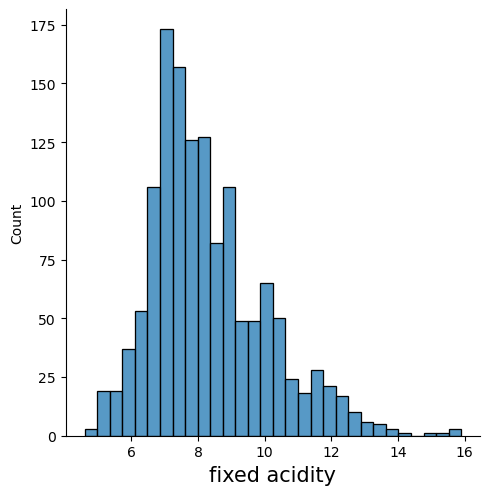

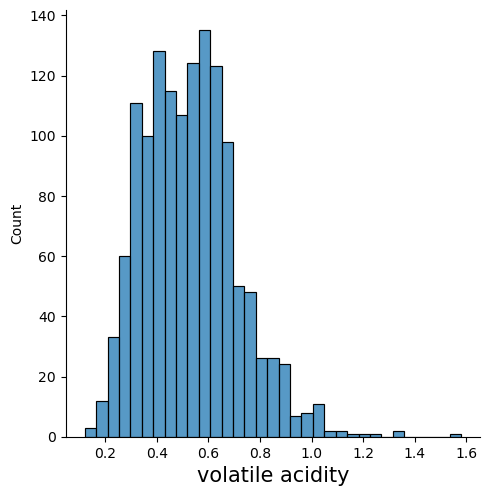

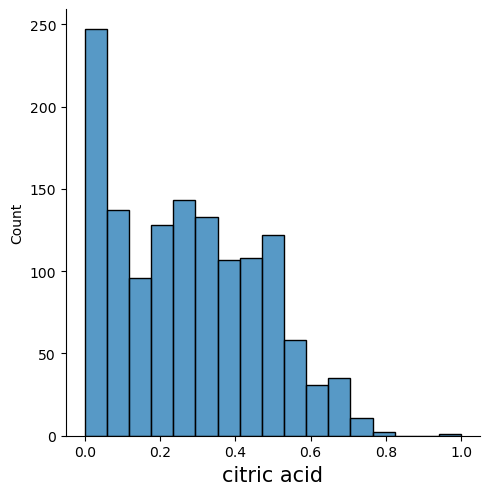

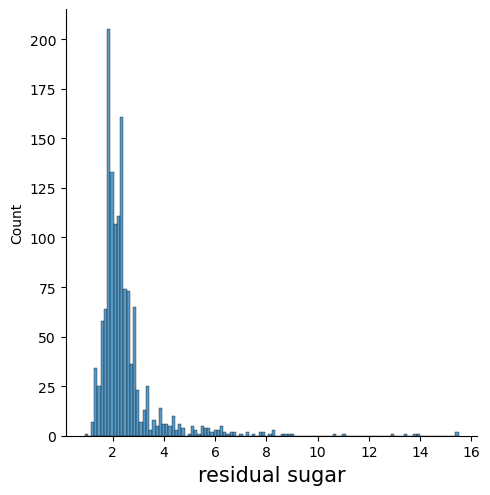

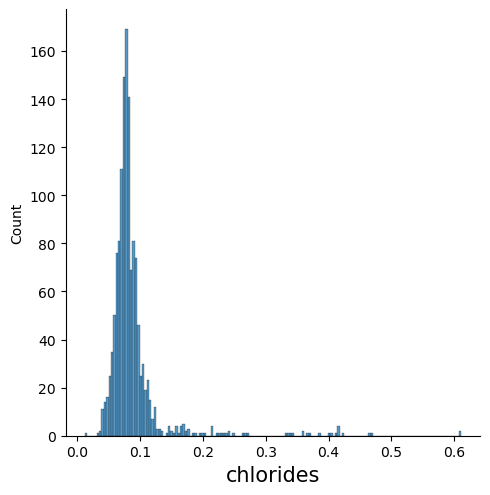

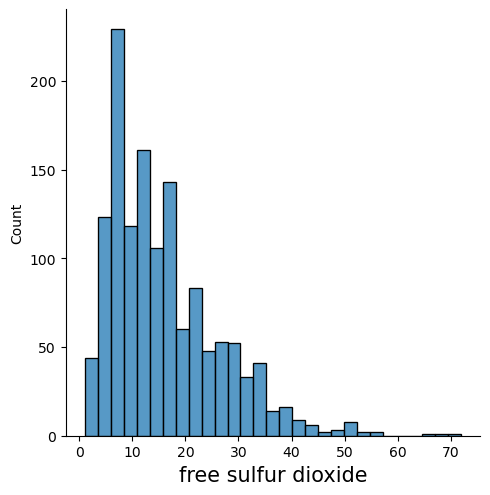

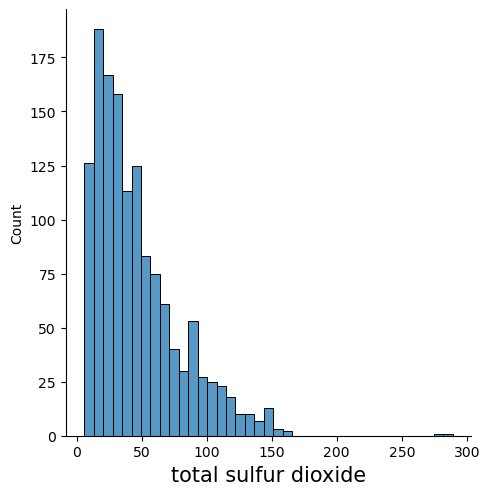

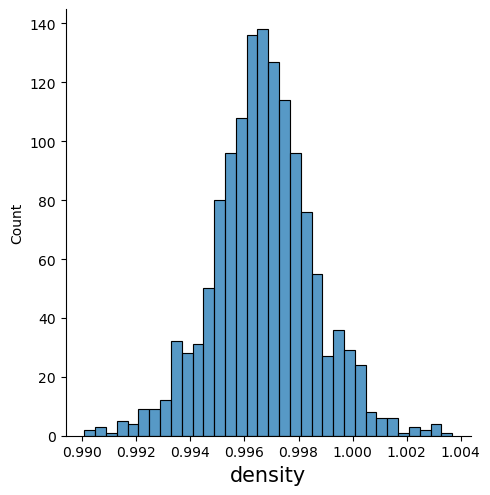

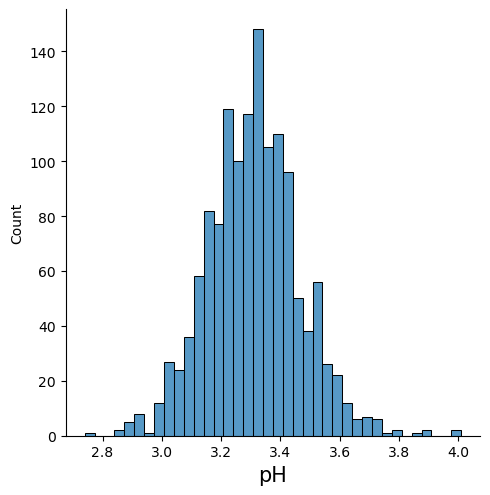

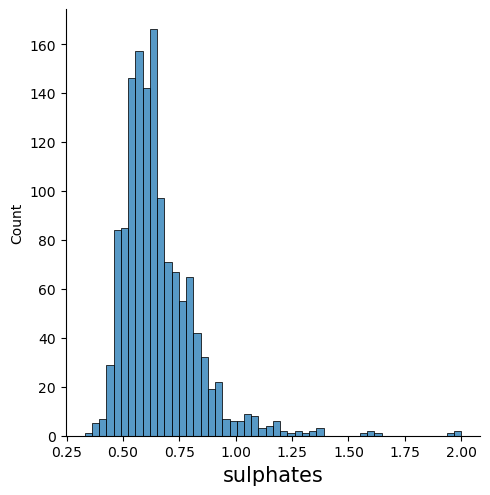

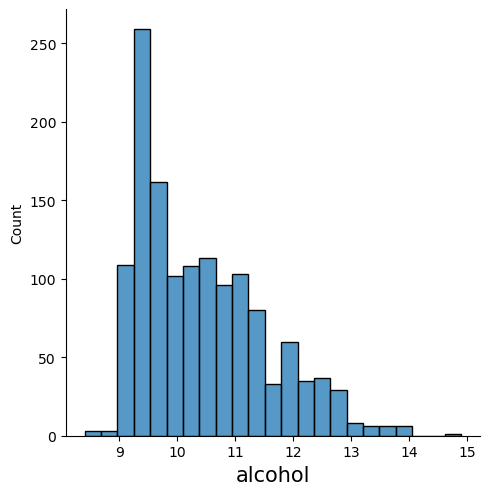

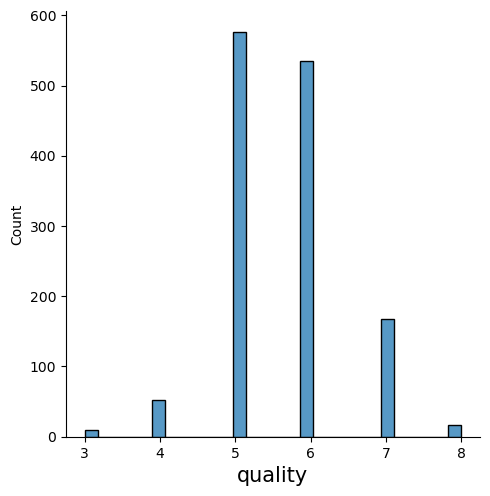

In [20]:
for col in df:
    sns.displot(df[col])
    plt.xlabel(col, fontsize = 15)
plt.show()


Text(0.5, 1.0, 'Quality vs Fixed Acidity')

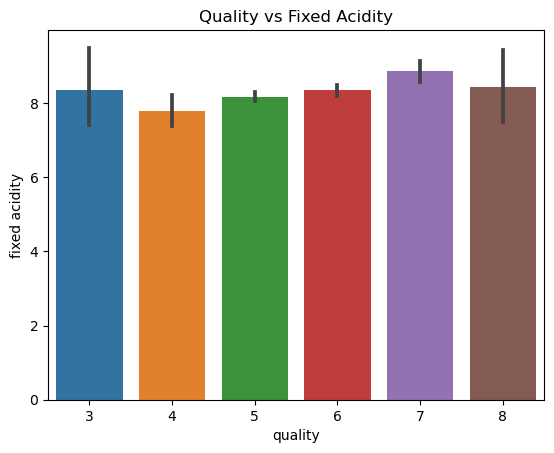

In [21]:
sns.barplot(x='quality', y='fixed acidity', data=df)
plt.title('Quality vs Fixed Acidity')


Text(0.5, 1.0, 'Quality vs Volatile Acidity')

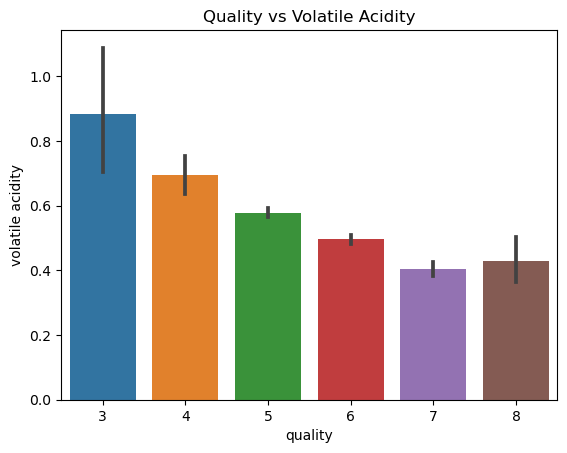

In [24]:
sns.barplot(data = df, x='quality', y='volatile acidity')
plt.title('Quality vs Volatile Acidity')

Text(0.5, 1.0, 'Quality vs Citric Acid')

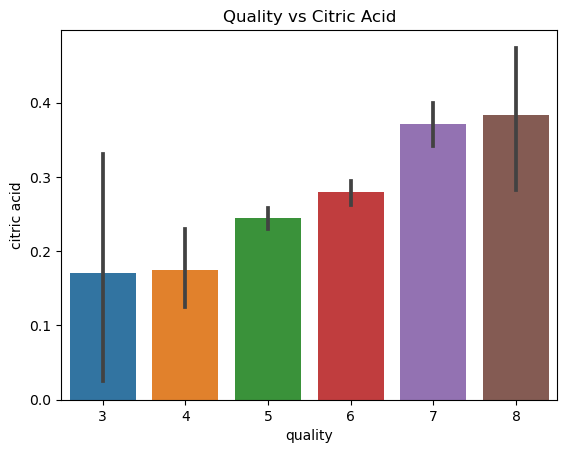

In [26]:
sns.barplot(data = df, x='quality', y='citric acid')
plt.title("Quality vs Citric Acid")

Text(0.5, 1.0, 'Quality vs Residual Sugar')

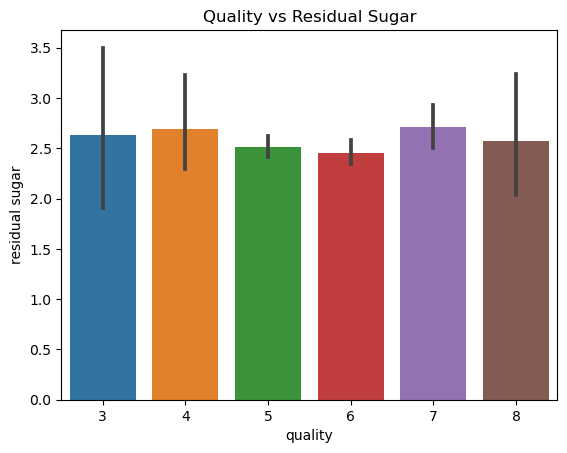

In [28]:
sns.barplot(data=df, x='quality', y='residual sugar')
plt.title("Quality vs Residual Sugar")

Text(0.5, 1.0, 'Quality vs Chlorides')

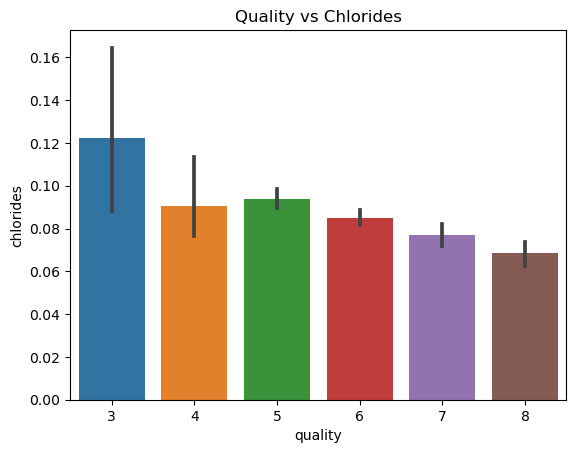

In [30]:
sns.barplot(data=df, x='quality', y='chlorides')
plt.title('Quality vs Chlorides')

Text(0.5, 1.0, 'Quality vs Free Sulfur Dioxide')

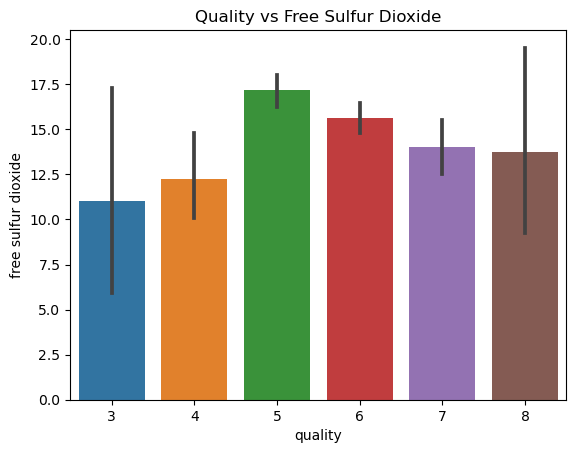

In [32]:
sns.barplot(data=df, x='quality', y='free sulfur dioxide')
plt.title('Quality vs Free Sulfur Dioxide')

Text(0.5, 1.0, 'Quality vs Total Sulfur Dioxide')

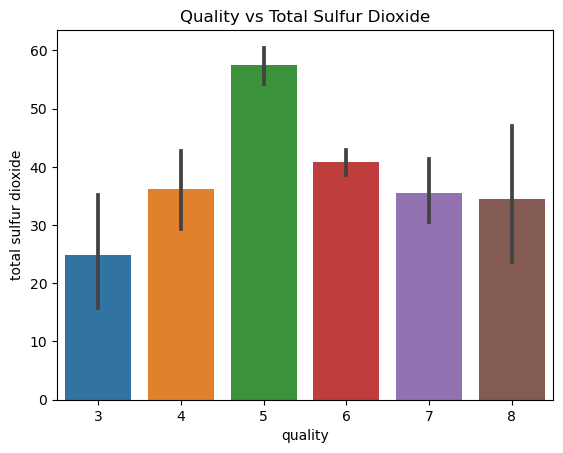

In [34]:
sns.barplot(data=df, x='quality', y='total sulfur dioxide')
plt.title('Quality vs Total Sulfur Dioxide')

Text(0.5, 1.0, 'Quality vs Density')

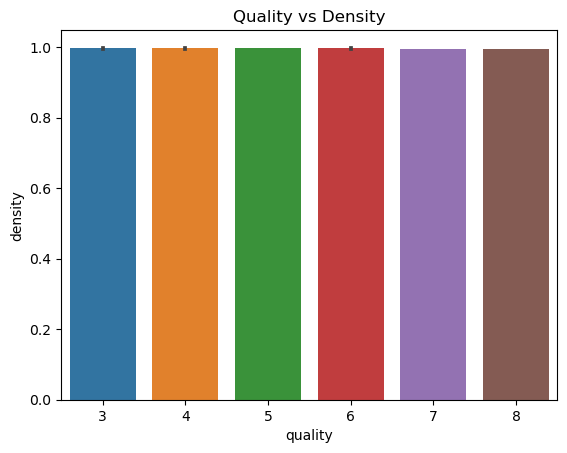

In [36]:
sns.barplot(data=df, x='quality', y='density')
plt.title("Quality vs Density")

Text(0.5, 1.0, 'Quality vs pH')

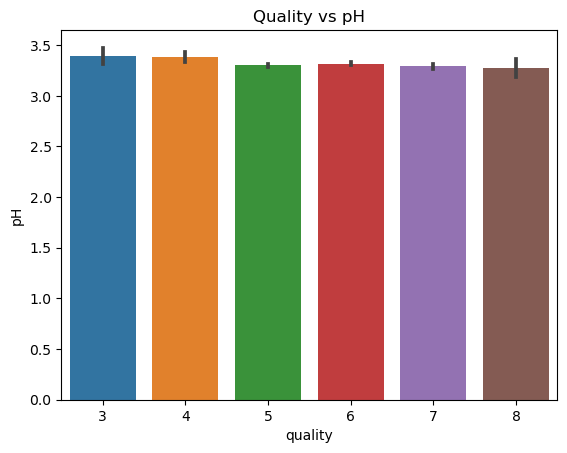

In [38]:
sns.barplot(data=df, x='quality', y='pH')
plt.title('Quality vs pH')

Text(0.5, 1.0, 'Quality vs Sulphates')

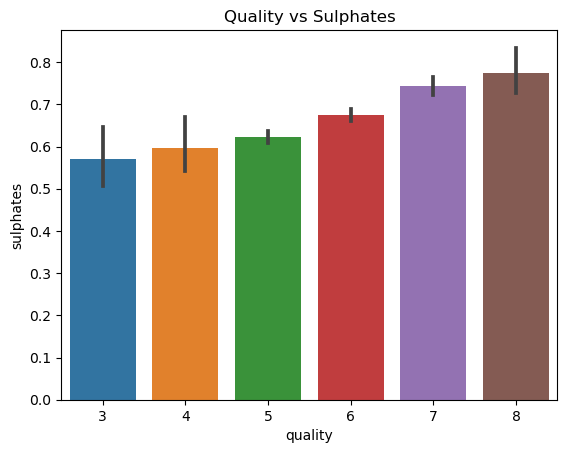

In [40]:
sns.barplot(data=df, x='quality', y='sulphates')
plt.title('Quality vs Sulphates')

In [42]:
X = df.drop('quality', axis=1)
y = df['quality']

# Split the full dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X.info())
print(X.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
dtypes: float64(11)
memory usage: 127.4 KB
None
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0

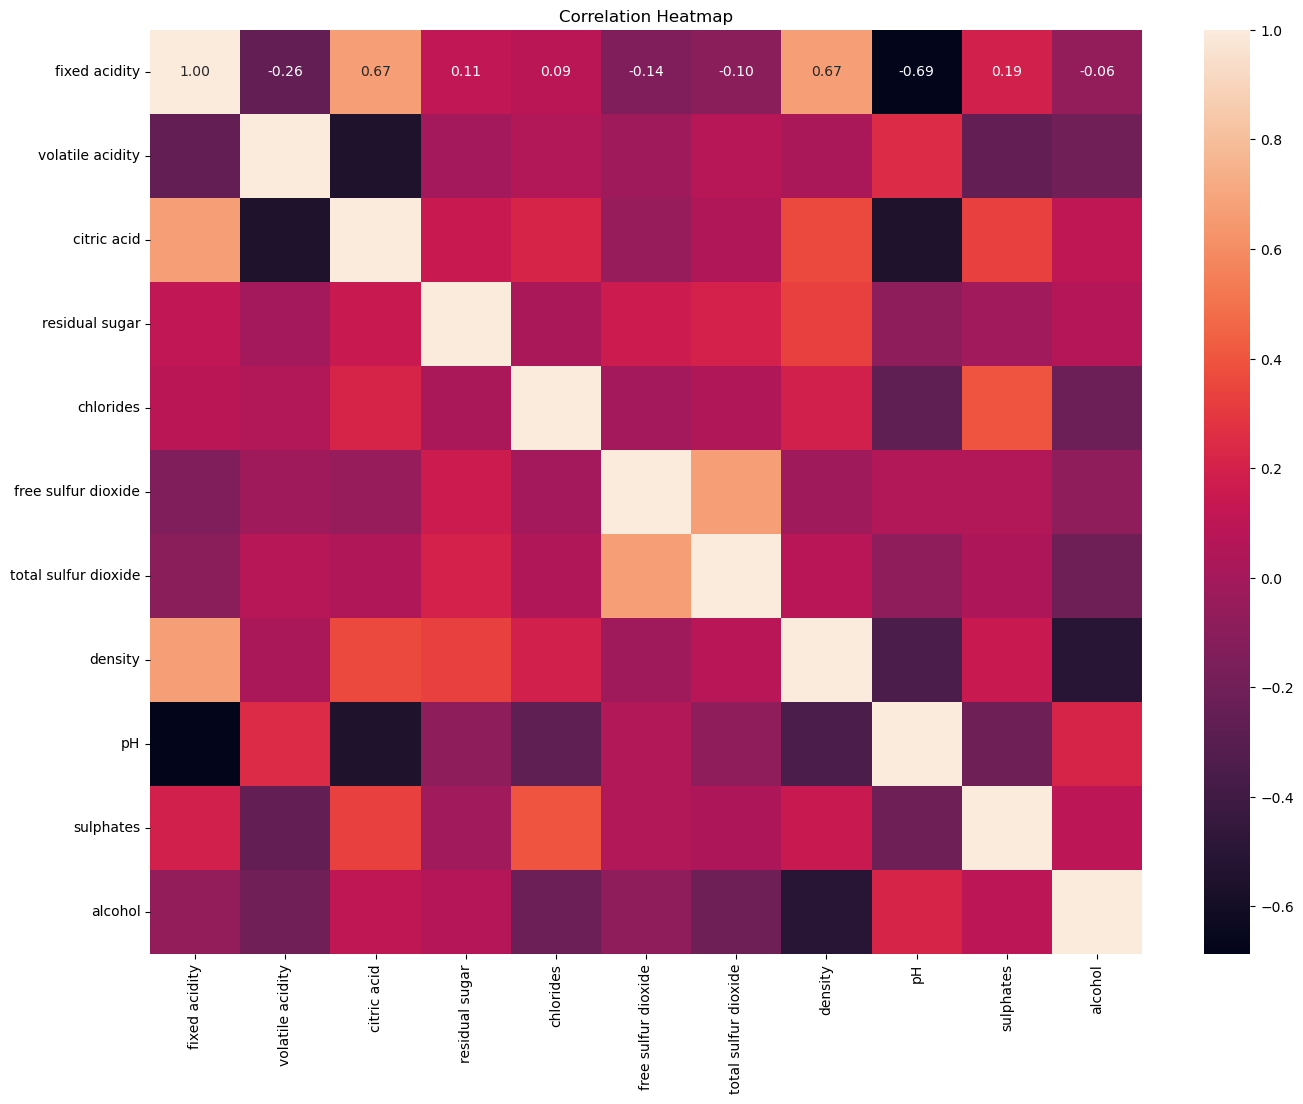

In [44]:
corr_matrix = X.corr()

plt.figure(figsize = (16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

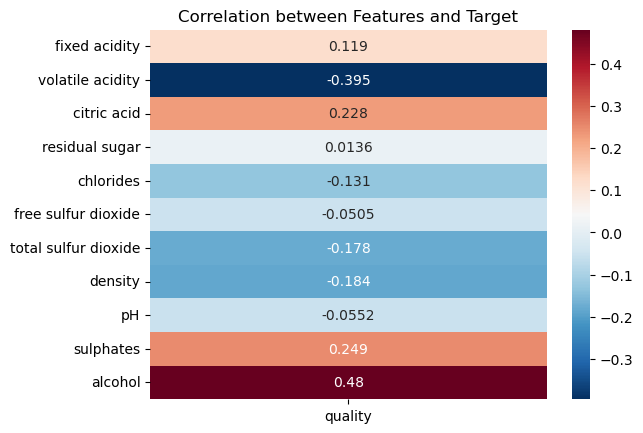

In [46]:
#Correlation between Features and Target

X_y = X.copy()
X_y['quality'] = y

corr_matrix = X_y.corr()

corr_target = corr_matrix[['quality']].drop(labels=['quality'])

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.title('Correlation between Features and Target')
plt.show()

# Preprocessing Data

In [49]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Logistic Regression

In [187]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_acc_test = accuracy_score(y_test, y_pred)

print(f"{lr.__class__.__name__}:\n")
print(f"Accuracy: {lr_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

LogisticRegression:

Accuracy: 0.6127

Confusion Matrix: 
[[  1   1   1   0   0   0]
 [  0   2   8   7   0   0]
 [  0   1 138  38   3   0]
 [  0   0  51  93  12   0]
 [  0   0   2  25  16   0]
 [  0   0   0   5   4   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      0.12      0.19        17
           2       0.69      0.77      0.73       180
           3       0.55      0.60      0.57       156
           4       0.46      0.37      0.41        43
           5       0.00      0.00      0.00         9

    accuracy                           0.61       408
   macro avg       0.53      0.36      0.40       408
weighted avg       0.59      0.61      0.59       408


-------------------------------------------------------



# K Nearest Neighbors

In [220]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_acc_test = accuracy_score(y_test, y_pred)

print(f"{knn.__class__.__name__}:\n")
print(f"Accuracy: {knn_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

KNeighborsClassifier:

Accuracy: 0.5662

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  0   1  12   4   0   0]
 [  0   4 129  45   2   0]
 [  0   1  57  85  13   0]
 [  0   0   6  21  16   0]
 [  0   0   1   5   3   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.17      0.06      0.09        17
           2       0.62      0.72      0.66       180
           3       0.53      0.54      0.54       156
           4       0.47      0.37      0.42        43
           5       0.00      0.00      0.00         9

    accuracy                           0.57       408
   macro avg       0.30      0.28      0.28       408
weighted avg       0.53      0.57      0.55       408


-------------------------------------------------------



In [222]:
#Hyperparameter Tuning

tuned_parameters = {'n_neighbors' : [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]}

grid_search = GridSearchCV(knn, param_grid=tuned_parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31]})

In [224]:
print('The best parameters for the SGD Classifier model are')
print(grid_search.best_params_)
print('\nWhich gives a best accuracy score with the training data of')
print(grid_search.best_score_)

The best parameters for the SGD Classifier model are
{'n_neighbors': 27}

Which gives a best accuracy score with the training data of
0.5804519151281344


In [218]:
knn_tuned = KNeighborsClassifier(n_neighbors = 27)
knn_tuned.fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)
knn_tuned_acc_test = ada_tuned.score(X_test, y_test)

print(f"{knn_tuned.__class__.__name__}:\n")
print(f"Accuracy: {knn_tuned_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

KNeighborsClassifier:

Accuracy: 0.5735

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  0   0  12   5   0   0]
 [  0   0 129  48   3   0]
 [  0   0  44 102  10   0]
 [  0   0   3  29  11   0]
 [  0   0   0   5   4   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        17
           2       0.68      0.72      0.70       180
           3       0.54      0.65      0.59       156
           4       0.39      0.26      0.31        43
           5       0.00      0.00      0.00         9

    accuracy                           0.59       408
   macro avg       0.27      0.27      0.27       408
weighted avg       0.55      0.59      0.57       408


-------------------------------------------------------



# Support Vector Machine

In [253]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
svc_acc_test = accuracy_score(y_test, y_pred)

print(svc.kernel, svc.C, svc.gamma)
print(f"{svc.__class__.__name__}:\n")
print(f"Accuracy: {svc_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

rbf 1.0 scale
SVC:

Accuracy: 0.6176

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  0   0  13   4   0   0]
 [  0   0 139  40   1   0]
 [  0   0  47 103   6   0]
 [  0   0   4  29  10   0]
 [  0   0   0   7   2   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        17
           2       0.67      0.77      0.72       180
           3       0.56      0.66      0.61       156
           4       0.53      0.23      0.32        43
           5       0.00      0.00      0.00         9

    accuracy                           0.62       408
   macro avg       0.29      0.28      0.28       408
weighted avg       0.57      0.62      0.58       408


-------------------------------------------------------



# Stochastic Gradient Descent (SGD) Classifier

In [177]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
sgd_acc_test = accuracy_score(y_test, y_pred)

print(f"{sgd.__class__.__name__}:\n")
print(f"Accuracy: {sgd_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

SGDClassifier:

Accuracy: 0.5588

Confusion Matrix: 
[[  0   1   2   0   0   0]
 [  0   3  12   2   0   0]
 [  0   0 144  35   1   0]
 [  1   5  68  67  15   0]
 [  0   0   3  26  14   0]
 [  0   0   0   6   3   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.33      0.18      0.23        17
           2       0.63      0.80      0.70       180
           3       0.49      0.43      0.46       156
           4       0.42      0.33      0.37        43
           5       0.00      0.00      0.00         9

    accuracy                           0.56       408
   macro avg       0.31      0.29      0.29       408
weighted avg       0.52      0.56      0.53       408


-------------------------------------------------------



In [121]:
#Hyperparameter Tuning

tuned_parameters = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1],
                    'loss' : ['hinge', 'log'],
                    'penalty' : ['l1', 'l2']
                   }

grid_search = GridSearchCV(sgd, param_grid=tuned_parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [123]:
print('The best parameters for the SGD Classifier model are')
print(grid_search.best_params_)
print('\nWhich gives a best accuracy score with the training data of')
print(grid_search.best_score_)

The best parameters for the SGD Classifier model are
{'alpha': 0.1, 'loss': 'log', 'penalty': 'l2'}

Which gives a best accuracy score with the training data of
0.564662441443924


In [125]:
sgd_tuned = SGDClassifier(alpha = 0.1, loss = 'log', penalty = 'l2')
sgd_tuned.fit(X_train, y_train)
y_pred = sgd_tuned.predict(X_test)
sgd_tuned_acc_test = accuracy_score(y_test, y_pred)

print(f"Tuned {sgd_tuned.__class__.__name__}:\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

Tuned SGDClassifier:

Accuracy: 0.5760

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  0   0  11   6   0   0]
 [  0   0 142  37   1   0]
 [  0   0  63  93   0   0]
 [  0   0   3  40   0   0]
 [  0   0   0   9   0   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        17
           2       0.64      0.79      0.71       180
           3       0.50      0.60      0.55       156
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00         9

    accuracy                           0.58       408
   macro avg       0.19      0.23      0.21       408
weighted avg       0.47      0.58      0.52       408


-------------------------------------------------------



# Decision Tree

In [259]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
dt_acc_test = dt.score(X_test, y_test)

print(f"{dt.__class__.__name__}:\n")
print(f"Decision Tree Max Depth: {dt.get_depth()}\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

DecisionTreeClassifier:

Decision Tree Max Depth: 19

Accuracy: 0.4730

Confusion Matrix: 
[[  0   1   0   2   0   0]
 [  0   4   5   5   3   0]
 [  1   7 100  61  10   1]
 [  0   4  44  76  31   1]
 [  0   0   7  23  12   1]
 [  0   0   1   5   2   1]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.24      0.24        17
           2       0.64      0.56      0.59       180
           3       0.44      0.49      0.46       156
           4       0.21      0.28      0.24        43
           5       0.25      0.11      0.15         9

    accuracy                           0.47       408
   macro avg       0.30      0.28      0.28       408
weighted avg       0.49      0.47      0.48       408


-------------------------------------------------------



# Random Forest

In [262]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_acc_test = rf.score(X_test, y_test)

print(f"{rf.__class__.__name__}:\n")
print(f"Accuracy: {rf_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

RandomForestClassifier:

Accuracy: 0.6201

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  1   0  14   2   0   0]
 [  0   0 136  41   3   0]
 [  0   0  40 103  13   0]
 [  0   0   1  28  14   0]
 [  0   0   0   6   3   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        17
           2       0.70      0.76      0.73       180
           3       0.57      0.66      0.61       156
           4       0.42      0.33      0.37        43
           5       0.00      0.00      0.00         9

    accuracy                           0.62       408
   macro avg       0.28      0.29      0.28       408
weighted avg       0.57      0.62      0.59       408


-------------------------------------------------------



# Adaptive Boost Classifier (Ada Boost)

In [265]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
ada_acc_test = ada.score(X_test, y_test)

print(f"{ada.__class__.__name__}:\n")
print(f"Accuracy: {ada_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

AdaBoostClassifier:

Accuracy: 0.3480

Confusion Matrix: 
[[  0   1   1   1   0   0]
 [  4   2   5   6   0   0]
 [ 32  57  40  47   4   0]
 [  9  19  25 100   3   0]
 [  0   1   2  40   0   0]
 [  0   0   0   8   1   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.03      0.12      0.04        17
           2       0.55      0.22      0.32       180
           3       0.50      0.64      0.56       156
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00         9

    accuracy                           0.35       408
   macro avg       0.18      0.16      0.15       408
weighted avg       0.43      0.35      0.35       408


-------------------------------------------------------



In [267]:
# Hyperparameter Tuning

grid_param = {
    'n_estimators' : [40, 50, 70, 80, 100],
    'learning_rate' : [0.01, 0.1, 0.05, 0.5, 1, 10],
    'algorithm' : ['SAMME', 'SAMME.R']
}

grid_search = GridSearchCV(ada, grid_param, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.01, 0.1, 0.05, 0.5, 1, 10],
                         'n_estimators': [40, 50, 70, 80, 100]},
             verbose=1)

In [268]:
print('The best parameters for the SGD Classifier model are')
print(grid_search.best_params_)
print('\nWhich gives a best accuracy score with the training data of')
print(grid_search.best_score_)

The best parameters for the SGD Classifier model are
{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 40}

Which gives a best accuracy score with the training data of
0.5730890052356021


In [271]:
ada_tuned = AdaBoostClassifier(algorithm = 'SAMME', learning_rate = 0.5, n_estimators = 40)
ada_tuned.fit(X_train, y_train)
y_pred = ada_tuned.predict(X_test)
ada_tuned_acc_test = ada_tuned.score(X_test, y_test)

print(f"{ada_tuned.__class__.__name__}:\n")
print(f"Accuracy: {ada_tuned_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

AdaBoostClassifier:

Accuracy: 0.5735

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  0   0  11   6   0   0]
 [  0   0 130  45   5   0]
 [  0   0  50  96  10   0]
 [  0   0   1  34   8   0]
 [  0   0   0   7   2   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        17
           2       0.67      0.72      0.69       180
           3       0.51      0.62      0.56       156
           4       0.32      0.19      0.24        43
           5       0.00      0.00      0.00         9

    accuracy                           0.57       408
   macro avg       0.25      0.25      0.25       408
weighted avg       0.52      0.57      0.54       408


-------------------------------------------------------



# Gradient Boosting Classifier

In [304]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_acc_test = gb.score(X_test, y_test)

print(f"{gb.__class__.__name__}:\n")
print(f"Accuracy: {gb_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

GradientBoostingClassifier:

Accuracy: 0.6005

Confusion Matrix: 
[[  0   3   0   0   0   0]
 [  1   0  13   3   0   0]
 [  1   1 134  40   3   1]
 [  0   0  46  94  16   0]
 [  0   0   2  24  17   0]
 [  0   0   0   7   2   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        17
           2       0.69      0.74      0.71       180
           3       0.56      0.60      0.58       156
           4       0.45      0.40      0.42        43
           5       0.00      0.00      0.00         9

    accuracy                           0.60       408
   macro avg       0.28      0.29      0.29       408
weighted avg       0.56      0.60      0.58       408


-------------------------------------------------------



# Stochastic Gradient Boosting Classifier (SGB)

In [307]:
sgb = GradientBoostingClassifier(max_features = 0.9, subsample = 0.8)
sgb.fit(X_train, y_train)
y_pred = sgb.predict(X_test)
sgb_acc_test = accuracy_score(y_test, y_pred)

print(f"{sgb.__class__.__name__}:\n")
print(f"Accuracy: {sgb_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

GradientBoostingClassifier:

Accuracy: 0.5956

Confusion Matrix: 
[[  1   0   2   0   0   0]
 [  1   2  11   3   0   0]
 [  2   1 132  41   3   1]
 [  0   2  44  92  17   1]
 [  0   0   2  27  13   1]
 [  0   0   0   3   3   3]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.40      0.12      0.18        17
           2       0.69      0.73      0.71       180
           3       0.55      0.59      0.57       156
           4       0.36      0.30      0.33        43
           5       0.50      0.33      0.40         9

    accuracy                           0.60       408
   macro avg       0.46      0.40      0.41       408
weighted avg       0.58      0.60      0.59       408


-------------------------------------------------------



# Extreme Gradient Boosting Classifier (XgBoost)

In [309]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_acc_test = accuracy_score(y_test, y_pred)

print(f"{xgb.__class__.__name__}:\n")
print(f"Accuracy: {xgb_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

None None None
XGBClassifier:

Accuracy: 0.5858

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  0   2  12   3   0   0]
 [  0   2 126  48   4   0]
 [  0   0  45  94  17   0]
 [  0   0   2  25  16   0]
 [  0   0   0   6   2   1]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.12      0.19        17
           2       0.67      0.70      0.68       180
           3       0.53      0.60      0.57       156
           4       0.41      0.37      0.39        43
           5       1.00      0.11      0.20         9

    accuracy                           0.59       408
   macro avg       0.52      0.32      0.34       408
weighted avg       0.59      0.59      0.57       408


-------------------------------------------------------



# Light Gradient Boosting Classifier

In [325]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_acc_test = accuracy_score(y_test, y_pred)

print(f"\n{lgbm.__class__.__name__}:\n")
print(f"Accuracy: {lgbm_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 951, number of used features: 11
[LightGBM] [Info] Start training from score -4.911604
[LightGBM] [Info] Start training from score -3.273995
[LightGBM] [Info] Start training from score -0.873578
[LightGBM] [Info] Start training from score -0.919978
[LightGBM] [Info] Start training from score -2.037232
[LightGBM] [Info] Start training from score -4.778073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

# Categorical Boosting Classifier (CatBoost)

In [327]:
cat = CatBoostClassifier()
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
cat_acc_test = accuracy_score(y_test, y_pred)

print(f"\n{cat.__class__.__name__}:\n")
print(f"Accuracy: {cat_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')

Learning rate set to 0.078924
0:	learn: 1.6940816	total: 8.94ms	remaining: 8.93s
1:	learn: 1.6140592	total: 16ms	remaining: 8s
2:	learn: 1.5414039	total: 23.5ms	remaining: 7.8s
3:	learn: 1.4822110	total: 31.2ms	remaining: 7.76s
4:	learn: 1.4288459	total: 39.5ms	remaining: 7.86s
5:	learn: 1.3786458	total: 47ms	remaining: 7.78s
6:	learn: 1.3357461	total: 54.6ms	remaining: 7.74s
7:	learn: 1.2972066	total: 62.5ms	remaining: 7.75s
8:	learn: 1.2630161	total: 70.8ms	remaining: 7.8s
9:	learn: 1.2352821	total: 77.6ms	remaining: 7.68s
10:	learn: 1.2070626	total: 84.9ms	remaining: 7.63s
11:	learn: 1.1811323	total: 91.7ms	remaining: 7.55s
12:	learn: 1.1585920	total: 98.2ms	remaining: 7.46s
13:	learn: 1.1362473	total: 105ms	remaining: 7.37s
14:	learn: 1.1170535	total: 111ms	remaining: 7.3s
15:	learn: 1.0995600	total: 118ms	remaining: 7.26s
16:	learn: 1.0823258	total: 124ms	remaining: 7.16s
17:	learn: 1.0664932	total: 131ms	remaining: 7.13s
18:	learn: 1.0510638	total: 139ms	remaining: 7.16s
19:	lear

# Extra Trees Classifier

In [330]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)
etc_acc_test = accuracy_score(y_test, y_pred)

print(f"\n{etc.__class__.__name__}:\n")
print(f"Accuracy: {etc_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')


ExtraTreesClassifier:

Accuracy: 0.6250

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  1   0  11   5   0   0]
 [  0   0 137  41   2   0]
 [  0   0  40 105  11   0]
 [  0   0   2  28  13   0]
 [  0   0   0   7   2   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        17
           2       0.71      0.76      0.73       180
           3       0.56      0.67      0.61       156
           4       0.46      0.30      0.37        43
           5       0.00      0.00      0.00         9

    accuracy                           0.62       408
   macro avg       0.29      0.29      0.29       408
weighted avg       0.58      0.62      0.60       408


-------------------------------------------------------



# Gaussian Naive Bayes Classifier

In [333]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
gnb_acc_test = accuracy_score(y_test, y_pred)

print(f"\n{etc.__class__.__name__}:\n")
print(f"Accuracy: {gnb_acc_test:.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')


ExtraTreesClassifier:

Accuracy: 0.5368

Confusion Matrix: 
[[  0   2   1   0   0   0]
 [  1   6   8   2   0   0]
 [  0  18 108  49   5   0]
 [  0   9  35  85  23   4]
 [  0   3   0  17  19   4]
 [  0   0   0   2   6   1]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.16      0.35      0.22        17
           2       0.71      0.60      0.65       180
           3       0.55      0.54      0.55       156
           4       0.36      0.44      0.40        43
           5       0.11      0.11      0.11         9

    accuracy                           0.54       408
   macro avg       0.31      0.34      0.32       408
weighted avg       0.57      0.54      0.55       408


-------------------------------------------------------



# MLP Neural Network Classifier

In [336]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_acc_test = accuracy_score(y_test, y_pred)

print(f"\n{etc.__class__.__name__}:\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}\n")
print('-'*55+'\n')


ExtraTreesClassifier:

Accuracy: 0.6127

Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  0   0  12   4   1   0]
 [  0   1 134  42   3   0]
 [  1   0  44  96  15   0]
 [  0   0   5  18  20   0]
 [  0   0   0   5   4   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        17
           2       0.68      0.74      0.71       180
           3       0.58      0.62      0.60       156
           4       0.47      0.47      0.47        43
           5       0.00      0.00      0.00         9

    accuracy                           0.61       408
   macro avg       0.29      0.30      0.30       408
weighted avg       0.57      0.61      0.59       408


-------------------------------------------------------



# Classifier Models Evaluation

In [342]:
models = pd.DataFrame({'Model' : ['Logistic Regression', 'K Nearest Neighbors', 'KNN Tuned', 'Support Vector Machine', 
                                  'SGD', 'SGD Tuned', 'Decision Tree', 'Random Forest', 'Ada Boost', 'Ada Boost Tuned',
                                  'Gradient Boosting', 'SGB', 'XgBoost', 'LGBM', 'CatBoost', 'Extra Trees', 'Gaussian Naive Bayes', 'MLP Neural Network'],
                       'Score': [lr_acc_test, knn_acc_test, knn_tuned_acc_test, svc_acc_test, sgd_acc_test, sgd_tuned_acc_test, 
                                 dt_acc_test, rf_acc_test, ada_acc_test, ada_tuned_acc_test, gb_acc_test, 
                                 sgb_acc_test, xgb_acc_test, lgbm_acc_test, cat_acc_test, etc_acc_test, gnb_acc_test, mlp_acc_test]
                      })
models = models.sort_values(by = 'Score', ascending = False)

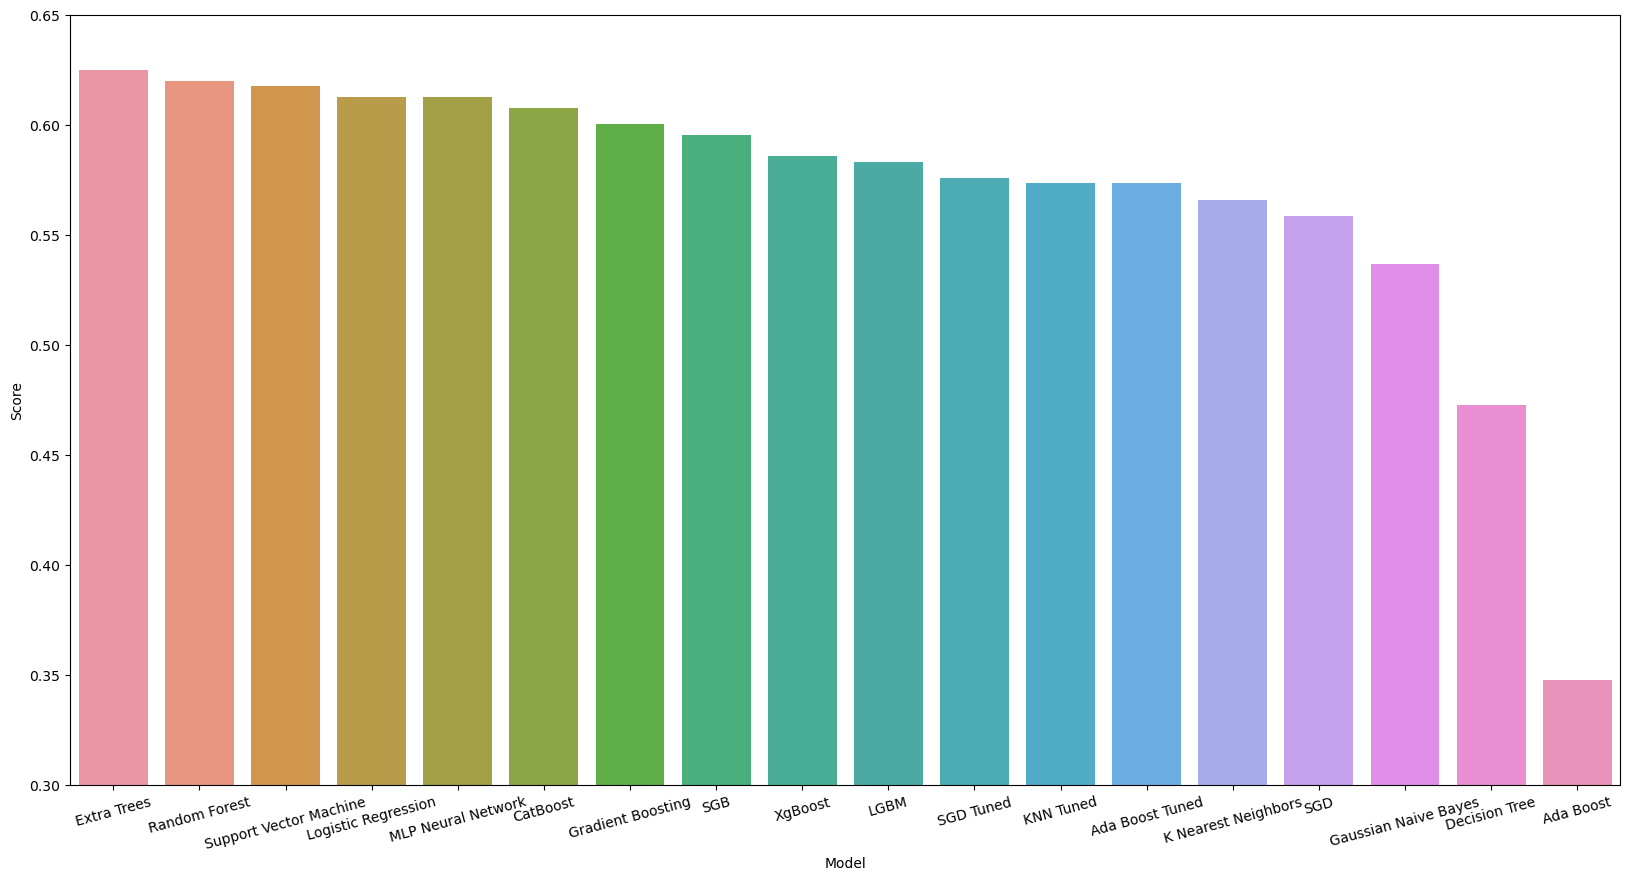

In [348]:
plt.figure(figsize = (20, 10))

sns.barplot(x = 'Model', y = 'Score', data = models)
plt.xticks(rotation = 15)
plt.ylim(0.30, 0.65)
plt.show()